### Setting up the Environment

In [1]:
!pip install pyspark


In [2]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Google Ads Optimization") \
    .getOrCreate()


### Loading the Dataset

In [3]:
# Load the dataset
data_path = "/content/50krecords.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Display the schema
df.printSchema()

# Show a sample of the data
df.show(5)


root
 |-- id: decimal(20,0) (nullable = true)
 |-- click: integer (nullable = true)
 |-- hour: timestamp (nullable = true)
 |-- C1: integer (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- site_id: string (nullable = true)
 |-- site_domain: string (nullable = true)
 |-- site_category: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_domain: string (nullable = true)
 |-- app_category: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_ip: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_type: integer (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |-- C14: integer (nullable = true)
 |-- C15: integer (nullable = true)
 |-- C16: integer (nullable = true)
 |-- C17: integer (nullable = true)
 |-- C18: integer (nullable = true)
 |-- C19: integer (nullable = true)
 |-- C20: integer (nullable = true)
 |-- C21: integer (nullable = true)

+--------------------+-----+------------

Explanation:

We read the CSV file using spark.read.csv() with header=True and inferSchema=True to automatically infer data types.
The printSchema() method displays the structure of the DataFrame.
The show(5) method displays the first five rows.

### Data Preprocessing

In [4]:
# Check for missing values
missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

# Drop rows with missing values (if any)
df = df.dropna()

# Convert 'hour' column to timestamp
# Make sure the 'hour' column is formatted correctly before conversion
df = df.withColumn('hour', to_timestamp('hour', 'yyyy-MM-dd HH:mm:ss'))

# Extract 'hour_of_day' and 'day_of_week'
df = df.withColumn('hour_of_day', hour('hour'))
df = df.withColumn('day_of_week', date_format('hour', 'E'))

# Show the transformed data
df.show(7)

+---+-----+----+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+---+---+---+---+---+---+---+---+
| id|click|hour| C1|banner_pos|site_id|site_domain|site_category|app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|C14|C15|C16|C17|C18|C19|C20|C21|
+---+-----+----+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+---+---+---+---+---+---+---+---+
|  0|    0|   0|  0|         0|      0|          0|            0|     0|         0|           0|        0|        0|           0|          0|               0|  0|  0|  0|  0|  0|  0|  0|  0|
+---+-----+----+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+---+---+---+---+---+---+---+---+

+--------------------+-----+----------------

Explanation:

We check for missing values in each column.
Drop rows with missing values using dropna().
Convert the hour column to a timestamp.
Extract hour_of_day and day_of_week for time-based analysis.

### Exploratory Data Analysis

In [5]:
# Calculate CTR
total_clicks = df.filter(col('click') == 1).count()
total_impressions = df.count()
ctr = (total_clicks / total_impressions) * 100
print(f"Click-Through Rate (CTR): {ctr:.2f}%")


Click-Through Rate (CTR): 16.93%


Explanation:

Calculate the total number of clicks and impressions.
Compute CTR as a percentage.

### Visualizing CTR by hour of the day

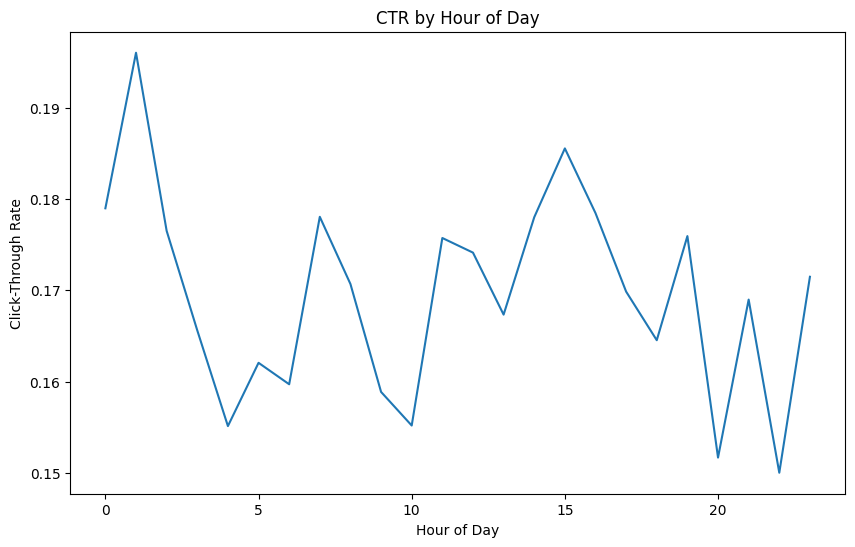

In [6]:
# Aggregate clicks by hour_of_day
ctr_by_hour = df.groupBy('hour_of_day').agg(
    (sum(col('click')) / count(col('click'))).alias('ctr')
).orderBy('hour_of_day')

# Convert to Pandas for plotting
ctr_by_hour_pd = ctr_by_hour.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=ctr_by_hour_pd, x='hour_of_day', y='ctr')
plt.title('CTR by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Click-Through Rate')
plt.show()


Explanation:

Group data by hour_of_day and calculate CTR.
Convert to a Pandas DataFrame for plotting with matplotlib and `seaborn`.

### Feature Engineering

#### a. Encoding Categorical Variables

In [7]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# List of categorical columns to encode
categorical_cols = ['C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type']

# Indexing and Encoding stages
stages = []
for col_name in categorical_cols:
    string_indexer = StringIndexer(inputCol=col_name, outputCol=col_name + '_Index')
    # Set dropLast=False to include all categories
    encoder = OneHotEncoder(inputCol=col_name + '_Index', outputCol=col_name + '_Vec', dropLast=False)
    stages += [string_indexer, encoder]

# Build and fit the pipeline
pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(df)
df = pipeline_model.transform(df)


Explanation:

Use `StringIndexer` to convert string categories to numerical indices.
Use `OneHotEncoder` to convert indices to one-hot encoded vectors.
Build a pipeline to streamline the transformation process.

#### b. Assembling Features

In [8]:
from pyspark.ml.feature import VectorAssembler

# List of feature columns
feature_cols = [col + '_Vec' for col in categorical_cols] + ['hour_of_day']

# Assemble feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df = assembler.transform(df)


Explanation:

Create a list of feature columns to include in the model.
Use `VectorAssembler` to combine feature columns into a single feature vector.

#### c. Extracting Feature names

### Model Training

#### a. Splitting the data

In [11]:
# Split the data into training and testing sets
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)


Explanation:

Split the data into 70% training and 30% testing sets for model evaluation.

#### b. Training a Logistic Regression Model

In [12]:
feature_names = assembler.getInputCols()

In [13]:
from pyspark.ml.classification import LogisticRegression

# Initialize the Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='click', maxIter=10)

# Train the model
lr_model = lr.fit(train_df)


Explanation:

Use logistic regression for binary classification of clicks.
Set `maxIter` to limit the number of iterations during training.

### Model Evaluation

In [14]:
# Make predictions on the test data
predictions = lr_model.transform(test_df)

# Evaluate the model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='click', metricName='areaUnderROC')
auc = evaluator.evaluate(predictions)
print(f"Test AUC: {auc:.4f}")


Test AUC: 0.6132


Explanation:

Use the trained model to make predictions on the test set.
Evaluate using Area Under the ROC Curve (AUC) metric.

### Analyzing Feature Importance

In [15]:
# Extract feature importances
import numpy as np

from pyspark.ml.feature import StringIndexerModel, OneHotEncoderModel

# Initialize dictionaries to hold the models
indexer_model_dict = {}
encoder_model_dict = {}

# Extract models from the pipeline
for stage in pipeline_model.stages:
    if isinstance(stage, StringIndexerModel):
        indexer_model_dict[stage.getOutputCol()] = stage
    elif isinstance(stage, OneHotEncoderModel):
        encoder_model_dict[stage.getOutputCol()] = stage

# Prepare the expanded feature names
expanded_feature_names = []

# For each input column in the VectorAssembler
for col_name in assembler.getInputCols():
    if col_name == 'hour_of_day':
        expanded_feature_names.append(col_name)
    else:
        # Get original column name by removing '_Vec'
        orig_col_name = col_name.replace('_Vec', '')
        # Get the corresponding StringIndexerModel
        indexer_model = indexer_model_dict[orig_col_name + '_Index']
        # Get category labels
        labels = indexer_model.labels
        # Add feature names for each category
        for label in labels:
            feature_name = f'{orig_col_name}_{label}'
            expanded_feature_names.append(feature_name)

# Get the coefficients from the model
coefficients = lr_model.coefficients.toArray()

# Ensure the lengths match
print(f"Number of expanded feature names: {len(expanded_feature_names)}")
print(f"Number of coefficients: {len(coefficients)}")

# Create a DataFrame for feature importances
fi_df = pd.DataFrame({
    'feature': expanded_feature_names,
    'importance': coefficients
})

# Sort features by absolute importance
fi_df['abs_importance'] = fi_df['importance'].abs()
fi_df.sort_values(by='abs_importance', ascending=False, inplace=True)

# Display the top features
print(fi_df[['feature', 'importance']].head(10))


Number of expanded feature names: 60
Number of coefficients: 60
                   feature  importance
47   app_category_2281a340   -4.068207
27  site_category_8fd0aea4   -3.800283
31  site_category_e787de0e   -3.800198
21  site_category_76b2941d   -3.781095
29  site_category_a818d37a   -3.756884
49   app_category_8df2e842   -3.625909
58      device_conn_type_5   -3.522538
45   app_category_0f9a328c   -3.497646
41   app_category_fc6fa53d   -3.447263
44   app_category_a3c42688    2.810969


Explanation:

Retrieve model coefficients to assess feature importance.
Use absolute values to rank features by their impact.
Display the top 10 most important features.


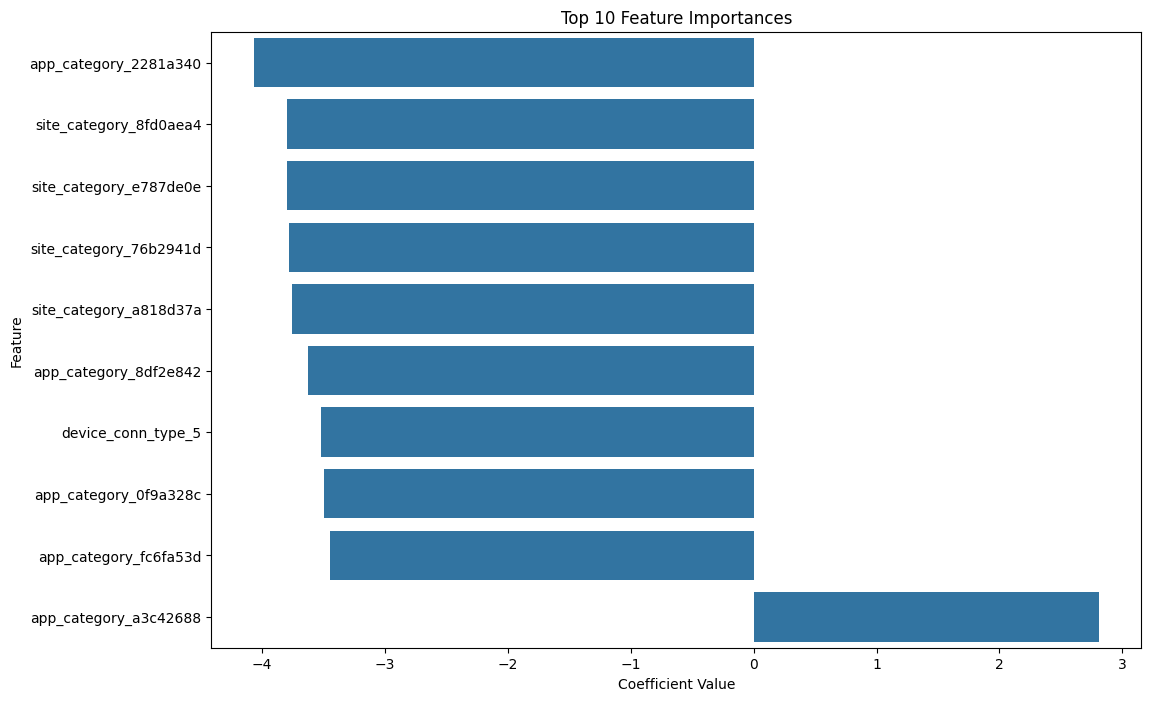

In [16]:
# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(data=fi_df.head(10), x='importance', y='feature', orient='h')
plt.title('Top 10 Feature Importances')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()


Explanation:

Use `seaborn` to create a horizontal bar plot of the top 10 features.
Visual aids help in understanding which features are most influential.


### Refining Target Mechanisms

#### a. Identifying Key Features

In [17]:
# Key features influencing clicks
key_features = fi_df['feature'].head(5).tolist()
print("Key features to focus on for targeting mechanisms:")
print(key_features)


Key features to focus on for targeting mechanisms:
['app_category_2281a340', 'site_category_8fd0aea4', 'site_category_e787de0e', 'site_category_76b2941d', 'site_category_a818d37a']


Explanation:

List out the top features that have the most significant impact on click prediction.

Recommendations:
- **Device Type and Connection Type:** If device_type and device_conn_type are among the top features, tailor ads for specific devices or connection types.

- **Time of Day:** Utilize hour_of_day to schedule ads during peak hours with higher CTR.

- **Site and App Categories:** Focus on high-performing site_category and app_category to improve relevance.


### Optimizing bidding strategies

#### a. Conversion Rates by Device Type

In [18]:
# Calculate conversion rates by device type
conversion_by_device = df.groupBy('device_type').agg(
    (sum(col('click')) / count(col('click'))).alias('conversion_rate')
).orderBy('conversion_rate', ascending=False)

conversion_by_device.show()


+-----------+-------------------+
|device_type|    conversion_rate|
+-----------+-------------------+
|          0|0.21501831501831503|
|          1| 0.1683380623361996|
|          5|0.10344827586206896|
|          4| 0.0970873786407767|
+-----------+-------------------+



Explanation:

Identify which device types have higher conversion rates.
Allocate more budget to device types with better performance.

#### b. Time based bidding

In [19]:
# Identify peak hours
peak_hours = ctr_by_hour_pd.sort_values(by='ctr', ascending=False).head(5)
print("Peak hours with highest CTR:")
print(peak_hours)

# Suggest increasing bids during these hours


Peak hours with highest CTR:
    hour_of_day       ctr
1             1  0.196000
15           15  0.185531
0             0  0.178977
16           16  0.178453
7             7  0.178047


Recommendations:

Increase Bids During Peak Hours: Allocate a higher portion of your budget during hours with higher CTR.
Optimize for High-Performing Devices: Adjust bids based on device types that yield better conversion rates.